# Andrew Ng's Machine Learning MOOC: Week 9: Anomaly Detection and Recommender Systems


# Programming Exercise 8

## 0. Introduction
This notebook contains my solutions to the programming exercise for week 9 of Andrew Ng's famous Machine Learning MOOC on Coursera (https://www.coursera.org/learn/machine-learning).

As in week 8 / programming exercise 8, this week's exercise comes in two parts (to match the two topics covered in this week's lectures) - which I've separated into two separate notebooks:
- In *this notebook* (the first part), we will implement a Guassian anomaly detection algorithm and apply it to detect failing servers on a network.
- In the second part, we will use collaborative filtering to build a recommender system for films.

Now, the course requires submission of programming exercises in either the MATLAB or OCTAVE programming language.
However since:
- I already code in Python for various web development and data science projects, and
- Python is the pre-eminent language currently used in data science and machine learning (and MATLAB and OCTAVE don't seem to be used anywhere near as much)
I decided it would be more valuable to me to use Python to complete the programming exercises.

I was therefore very pleased to find the following source, which has kindly written a set of python scripts to allow one to create Python implementations of the programming exercises for the course, and still submit them for scoring by the MOOC: https://github.com/dibgerge/ml-coursera-python-assignments

Thanks very much `dibgerge!`

In addition to the course's own lecture materials, I also used a number of other sources to help me solve the programming exercises. These include:

#### Other courses I've completed:
- Harvard's *Using Python for Research* on edX: https://www.edx.org/course/using-python-for-research
- UC San Diego's *Python for Data Science*, also on edX: https://www.edx.org/course/python-for-data-science-2
- MIT's *Introduction to Computational Thinking and Data Science I and II*, also on edX: https://www.edx.org/course/introduction-to-computational-thinking-and-data-4
- Imperial College London's *Mathematics for Machine Learning I-III* on Coursera: https://www.coursera.org/specializations/mathematics-machine-learning
- Goldsmith's / University of London's *Foundations of Data Science: K-means Clustering in Python* on Coursera: https://www.coursera.org/learn/data-science-k-means-clustering-python

#### Books:
- Python Machine Learning by Sebastian Raschka and Vahid Mirjalili: https://sebastianraschka.com/books.html

#### Blogs and websites
I found these blogs to be very useful references:
- https://www.johnwittenauer.net/machine-learning-exercises-in-python-part-8/
- http://sdsawtelle.github.io/blog/output/week9-anomaly-andrew-ng-machine-learning-with-python.html - as well as being a useful discussion of the programming exercise for this week, this blog was especially useful to illuminate some of the challenges and techniques for using `scikitlearn`'s `EllipticEnvelope` class for anomaly detection. Using `scikitlearn` goes beyond the scope of the exercise, but I was keen to use this "industry standard" ML library. I referred to this blog post extensively in relation to *section 1.4* below - thanks Sonya!

And of course, there's always StackOverflow!

One thing that struck me, looking at all of these different resources, is how many different ways there are to implement basically the same code in python, even using numpy and pandas dataframes! And that's before we think about object-oriented implementations, or using libraries such as `scikitlearn`.

OK, now that the introduction is complete, let's get started with some imports. You can find instructions on how to install required libraries in the README file in `dibgerge`'s github repository.

In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Data-wrangling library for python
import pandas as pd

# Plotting libraries
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Optimization module in scipy
from scipy import optimize

# Stats module in scipy
from scipy import stats

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# library written for this exercise providing additional functions for assignment submission, and others
import utils

# tells matplotlib to embed plots within the notebook
%matplotlib inline

## 1 Anomaly Detection 

In the first exercise, we will implement an anomaly detection algorithm to detect anomalous behavior in server computers.

To begin with we will start on a 2D dataset that will allow us to visualize what the algorithm is doing. Then we'll move on to an 11-dimensional dataset to see how the approach can generalize to any number of dimensions.

The set-up for the 2D element of the exercise is as follows: We have data on the performance of servers in a data centre. Specifically, we have measured throughput (in MB/s) and latency of response (in ms) of each server while they were operating, collecting $m = 307$ examples of how they were behaving.

As a result, we have an unlabeled dataset $\{x^{(1)}, \dots, x^{(m)}\}$. Our hypothesis is that the vast majority of these examples are of the servers operating normally - i.e. most of the examples are non-anomalous. However, their might also be some examples of servers acting anomalously within this dataset.

We will use a Gaussian model to detect anomalous examples in your dataset.  We will fit a Gaussian distribution to that dataset, and then find values that have very low probability and hence can be considered anomalies.

Following that, we will apply the anomaly detection algorithm to a larger dataset with many dimensions.

Let's load the data:

In [2]:
#  The following command loads the dataset.
data = loadmat(os.path.join('Data', 'ex8data1.mat'))
X, Xval, yval = data['X'], data['Xval'], data['yval'][:, 0]

Let's have a look at the dimensions of our data:

In [3]:
print("{}'s shape is {}".format("X", X.shape))
print("{}'s shape is {}".format("Xval", Xval.shape))
print("{}'s shape is {}".format("yval", yval.shape))

X's shape is (307, 2)
Xval's shape is (307, 2)
yval's shape is (307,)


So, we have:
- an *unlabelled* data set (`X`), containing 307 2-dimensional data points;
- a validation set (`Xval`), also containing 307 2-dimensional data points - plus labels for that validation set (`yval`).

Let's take a look at the unlabelled data set, 'X':

[<matplotlib.text.Text at 0x118081f60>, <matplotlib.text.Text at 0x118060898>]

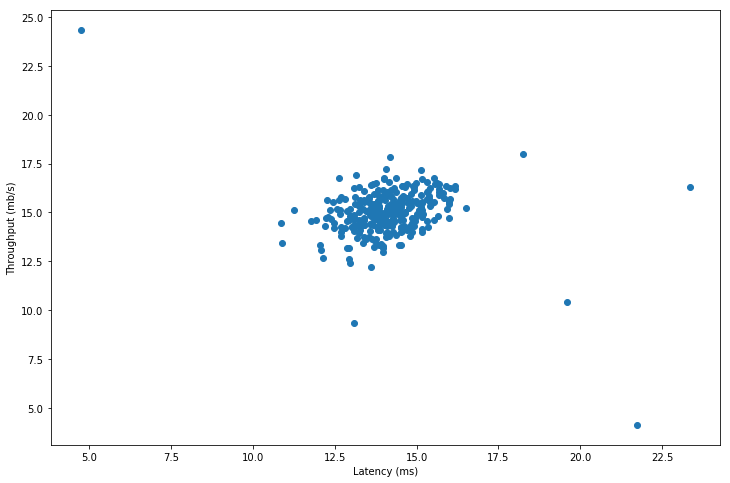

In [4]:
#  Visualize the example training dataset
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])
ax.set(xlabel='Latency (ms)', ylabel='Throughput (mb/s)')

We can see that there is a tight clustering of data points centred around a mean of something like (14, 15); along with maybe half-a-dozen outlying data points that might be considered anomalies.

Let's also take a look at our validation data set (`Xval`), colour-coding the values that have been defined as outliers (in `yval`).

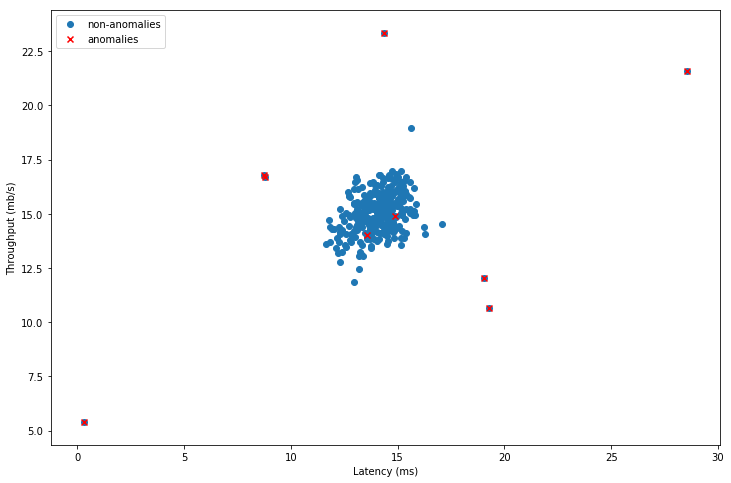

In [5]:
#  Visualize the example validation dataset
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(Xval[:,0], Xval[:,1], label = "non-anomalies")
ax.scatter(Xval[yval==1, 0], Xval[yval==1, 1], marker="x", color="r", label="anomalies")
ax.set(xlabel='Latency (ms)', ylabel='Throughput (mb/s)')
ax.legend(loc="upper left")

Again, we see a tight cluster of data points around a mean of something like (14, 15), and half-a-dozen data points further away. Moreover - because we have labelled data from `yval` - we can see there are actually 8 anomalous data points. Interestingly, two of these tight within the central cluster of points - so our Gaussian estimator is unlikely to identify these correctly - at least not without creating some new features from our data that could distinguish them.

Overall, our task in this exercise is to implement an anomaly detection algorithm that will identify outliers in our *unlabelled* data set (`X`) - so *un-supervised learning*. We will then apply this algorithm to the validation data set (`Xval`), and see how well it performs, by comparing predictions with the actual defined set of outliers (`yval`) for that data set (which people sometimes refer to with the jargon "ground truth").

### 1.1 Estimating the parameters for a Gaussian distribution

To perform anomaly detection, we will first need to "fit a model" to the data's distribution - i.e. calculate/estimate the parameters of a Gaussian distribution that fits the data. More formally:
- given a training set $\{x^{(1)}, \dots, x^{(m)} \}$ (where $x^{(i)} \in \mathbb{R}^n$ )
- we want to estimate the Gaussian distribution for each of the features $x_i$ .

For each feature $i = 1 \dots n$...

...we need to find parameters $\mu_i$ and $\sigma_i^2$  that fit the data in the $i^{th}$ dimension $\{ x_i^{(1)}, \dots, x_i^{(m)} \}$ (the $i^{th}$ dimension of each example).

The Gaussian distribution is given by

$$ p\left( x; \mu, \sigma^2 \right) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{\left(x-\mu\right)^2}{2\sigma^2}},$$
where $\mu$ is the mean and $\sigma^2$ is the variance.

We can estimate the parameters $\left( \mu_i, \sigma_i^2 \right)$, of the $i^{th}$ feature using the following equations. To estimate the mean:: 

$$ \mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)},$$

and for the variance:

$$ \sigma_i^2 = \frac{1}{m} \sum_{j=1}^m \left( x_i^{(j)} - \mu_i \right)^2.$$

Our first task is to complete the the function `estimateGaussian()`, which takes as input the data matrix `X` and needs to output:
- an n-dimension vector `mu` that holds the mean for each of the $n$ features; and
- an n-dimension vector `sigma2` that holds the variances of each of the features.

To be clear, in this first case, in which we have 2D data, our function needs to return two vectors of shape (2,), each of which will hold two values:
- the mean througput (in MB/s), and the mean latency (in ms)
- the variance of the throughput, and the variance of the latency

In [6]:
def estimateGaussian(X):
    """
    This function estimates the parameters of a Gaussian distribution
    using a provided dataset.
    
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n) with each n-dimensional 
        data point in one row, and each total of m data points.
    
    Returns
    -------
    mu : array_like 
        A vector of shape (n,) containing the means of each dimension.
    
    sigma2 : array_like
        A vector of shape (n,) containing the computed
        variances of each dimension.
    """
    mu = X.mean(axis=0)
    sigma_squared = X.var(axis=0)
    
    return mu, sigma_squared

Let's have a look at the Gaussian distribution we have "fitted" to the data $X$. The steps are as follows:
- first, we estimate the parameters of our assumed Gaussian distribution (using our `estimateGaussian()` function; 
- then we compute the probabilities for each of the points in X (using the function `multivariateGaussian()`);
- finally, we visualize both the overall distribution and where each of the points falls in terms of that distribution (using the function `visualizeFit()`).

means are [ 14.11222578  14.99771051]
variances are [ 1.83263141  1.70974533]


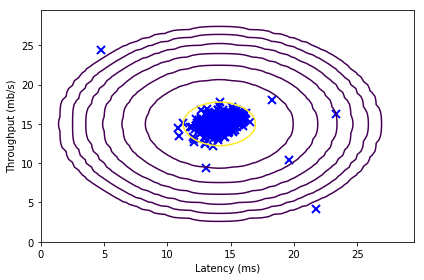

In [7]:
#  Estimate mu and sigma2
mu, sigma_squared = estimateGaussian(X)

print("means are {}".format(mu))
print("variances are {}".format(sigma_squared))

#  Returns the density of the multivariate Gaussian distribution at each data point (row) 
#  of X
p = utils.multivariateGaussian(X, mu, sigma_squared)

#  Visualize the fit
utils.visualizeFit(X,  mu, sigma_squared)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.tight_layout()

We can see that our "visual" estimate of the means was about right; and that we were correct that there is a tight probability distribution around the centre - certainly our farthest two outlying examples are a long way from the mean, and hence low probability.


#### 1.1.1 "Univariate" vs. multivariate Gaussian distribution

In the cell above that plotted our data, we called two functions that are provided by the course (and translated into `Python` by `dibgerge`) which you can find in `utils.py ` in `dibgerge`'s distribution. It's worth taking in particular at the `multivariateGaussian()` function to see how it works:

In [8]:
def multivariateGaussian(X, mu, Sigma_squared):
    """
    Computes the probability density function of the multivariate gaussian distribution.

    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n). Where there are m examples of n-dimensions.

    mu : array_like
        A vector of shape (n,) contains the means for each dimension (feature).

    Sigma_squared : array_like
        Either a vector of shape (n,) containing the variances of independent features
        (i.e. it is the diagonal of the correlation matrix), or the full
        correlation matrix of shape (n x n) which can represent dependent features.

    Returns
    ------
    p : array_like
        A vector of shape (m,) which contains the computed probabilities at each of the
        provided examples.
    """
    k = mu.size

    # if sigma is given as a diagonal, compute the matrix
    if Sigma_squared.ndim == 1:
        Sigma_squared = np.diag(Sigma_squared)

    X = X - mu
    p = (2 * np.pi) ** (- k / 2) * np.linalg.det(Sigma_squared) ** (-0.5)\
        * np.exp(-0.5 * np.sum(np.dot(X, np.linalg.pinv(Sigma_squared)) * X, axis=1))
    return p

We can see that this function is calculating the value of the multi-variate Gaussian distribution for each point in our training data:

$$ p\left(X; \mu, \Sigma \right) = \frac{1}{2\pi^{\frac{n}{2}}}e^-\left((x-\mu)^T\Sigma^{-1}(x-\mu))\right)$$


where $\mu$ is the vector of the means mean and $\Sigma$ is the co-variance matrix of the features in $X$



This formula is different formula from the "standard" equation to estimate the probability distribution function, which we set out above. It stated that,for any particular data point, $x^i$, of any feature, it's probability of belonging to a Gaussian distribution paramaterized by $\mu$ and $\sigma^2$ is given by:

$$ p\left( x; \mu, \sigma^2 \right) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{\left(x-\mu\right)^2}{2\sigma^2}},$$
where $\mu$ is the mean and $\sigma^2$ is the variance.

To calculate the probability of a data-point *defined by more than one feature*, we multiply each of the *feature* probabilities for that point together ((i.e. that row of the data). Expanding this concept, to calculate the probability distribution of all of the points, we multiply the probability vectors for each feature together.

**Note**, however, that the "product of feature probabilities" will only be the same as the multivariate case when all the features are *independent* of each other. If they aren't independent - that is to say, they co-vary in some degree - then the two calculations will give us different results.

Let's have a go at estimating the probability distribution function using the "standard" formula using `scipy`'s built-in methods. Let's do this for for our training data X:

In [9]:
# calculate probability distribution of each dimension in Xval,
# ...based on mu and sigma_squared previously estimated for training data X
p_calculated = np.zeros((X.shape[0], X.shape[1]))
p_calculated[:,0] = stats.norm(mu[0], sigma_squared[0]).pdf(X[:,0])
p_calculated[:,1] = stats.norm(mu[1], sigma_squared[1]).pdf(X[:,1])

In [10]:
p_calculated.shape

(307, 2)

Here we have calculated the probability distribution for each of the two features of $X$ separately. We now we need to combine the two "partial" probabilities (i.e. the probability for each dimension) and calculate the probability for the "whole" data point - which is simply the product of the probabilities for each dimension.

In [11]:
final_p_calculated = np.zeros((X.shape[0]))
final_p_calculated = p_calculated[:, 0] * p_calculated[:, 1]

In [12]:
final_p_calculated.shape

(307,)

In [13]:
final_p_calculated[0:10]

array([ 0.04241641,  0.03635799,  0.04477112,  0.03642082,  0.04164306,
        0.03276384,  0.03578026,  0.03077973,  0.02118433,  0.03714876])

In [14]:
p[0:10]

array([ 0.06470829,  0.05030417,  0.07245035,  0.05031575,  0.06368497,
        0.04245832,  0.04790945,  0.03651115,  0.0186658 ,  0.05068826])

We can see that the two calculations give different results - indicating that there is some co-variance between our two sets of features. Let's check that using `numpy`'s `cov()` method:

In [15]:
np.cov(X[:,0], X[:,1])

array([[ 1.83862041, -0.22786456],
       [-0.22786456,  1.71533273]])

We can see there is a small negative covariance between the two columns of X (i.e. between our two features).

### 1.2 Selecting the threshold, $\varepsilon$

Now that we have estimated the Gaussian parameters, we can investigate which examples have a very high probability given this distribution and which examples have a very low probability. The low probability examples are more likely to be the anomalies in our dataset.

One way to determine which examples are anomalies is to select a threshold based on a cross validation set.

In this part of the exercise, we will implement an algorithm to select the threshold $\varepsilon$ using the $F_1$ score on a cross validation set.


Our task is to complete the `selectThreshold()` function. For this, we will use a cross validation set $\{ (x_{cv}^{(1)}, y_{cv}^{(1)}), \dots, (x_{cv}^{(m_{cv})}, y_{cv}^{(m_{cv})})\}$, where the label $y = 1$ corresponds to an anomalous example, and $y = 0$ corresponds to a normal example. For each cross validation example, we will compute $p\left( x_{cv}^{(i)}\right)$. The vector of all of these probabilities $p\left( x_{cv}^{(1)}\right), \dots, p\left( x_{cv}^{(m_{cv})}\right)$ is passed to `selectThreshold()` in the vector `pval`. The corresponding labels $y_{cv}^{(1)} , \dots , y_{cv}^{(m_{cv})}$ are passed to the same function in the vector `yval`.

The `selectThreshold()` function needs to return two values; the first is the selected threshold $\varepsilon$. If an example $x$ has a low probability $p(x) < \varepsilon$, then it is considered to be an anomaly. The function should also return the $F_1$ score, which tells you how well you are doing on finding the "ground truth"
anomalies given a certain threshold. We will compute the $F_1$ (by computing how many examples the current threshold classifies correctly and incorrectly) for many different values of $\varepsilon$.

The $F_1$ score is computed using precision ($prec$) and recall ($rec$):

$$ F_1 = \frac{2 \cdot prec \cdot rec}{prec + rec}, $$

where:

$$ prec = \frac{tp}{tp + fp}  $$ 

$$ rec = \frac{tp}{tp + fn} $$

and where: 

- $tp$ is the number of true positives: it's actually an anomaly and our algorithm correctly classified it as an anomaly.

-  $fp$ is the number of false positives: it's actually not an anomaly, but our algorithm incorrectly classified it as an anomaly.
- $fn$ is the number of false negatives: it's actually an anomaly, but our algorithm incorrectly classified it as not being anomalous.

When we complete the code in `selectThreshold()`, we should see an optimal value for `epsilon` of about 8.99e-05.

In [16]:
def selectThreshold(yval, pval):
    """
    Finds the best threshold (epsilon) to use for selecting outliers based
    on the predicged results from a validation set, compared with the actual
    results for that validation set.
    
    Parameters
    ----------
    yval : array_like, shape (m, ).
        The actual labels of whether validation data points are anomalous or not
        == 1 if the data point is anamalous
        == 0 if the data point is not anomalous
    
    pval : array_like
        The precomputed vector of probabilities for our validation data,
        based on mu and sigma_squared parameters calculated from the training set.
        Shape is also (m, ).
    
    Returns
    -------
    bestEpsilon : array_like
        A vector of shape (n,) corresponding to optimal the threshold value.
    
    bestF1 : float
        The value for the best F1 score.
    """
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
   
    for epsilon in np.linspace(1.01*min(pval), max(pval), 1000):
        # define preds to be all values where the predicted value is less than epsilon
        preds = pval < epsilon
        
        # calculate no. of true positives, false positives...
        # ...and false negatives - for the outliers
        tp = np.sum(np.logical_and(preds == 1, yval == 1)).astype(float)
        fp = np.sum(np.logical_and(preds == 1, yval == 0)).astype(float)
        fn = np.sum(np.logical_and(preds == 0, yval == 1)).astype(float)
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        F1 = (2 * precision * recall) / (precision + recall)
        
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon

    return bestEpsilon, bestF1

Now let's run `selectThreshold()`, and plot the data with circles around the identified anomalies:

Best epsilon found using cross-validation: 9.00e-05
Best F1 on Cross Validation Set:  0.875000
   (you should see a value epsilon of about 8.99e-05)
   (you should see a Best F1 value of  0.875000)


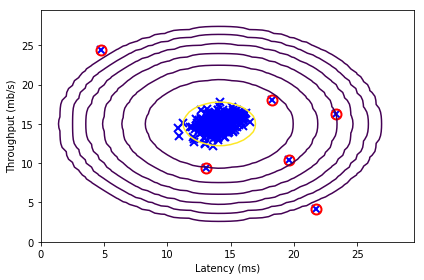

In [17]:
pval = utils.multivariateGaussian(Xval, mu, sigma_squared)

epsilon, F1 = selectThreshold(yval, pval)
print('Best epsilon found using cross-validation: %.2e' % epsilon)
print('Best F1 on Cross Validation Set:  %f' % F1)
print('   (you should see a value epsilon of about 8.99e-05)')
print('   (you should see a Best F1 value of  0.875000)')

#  Find the outliers in the training set and plot the
outliers = p < epsilon

#  Visualize the fit
utils.visualizeFit(X,  mu, sigma_squared)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.tight_layout()

#  Draw a red circle around those outliers
plt.plot(X[outliers, 0], X[outliers, 1], 'ro', ms=10, mfc='None', mew=2)
pass

### 1.3 Applying to a high-dimensional dataset

Now we will run the anomaly detection algorithm we implemented on a more realistic and much harder dataset. In this dataset, each example is described by 11 features - capturing many more properties of the performance of our servers - but only some features indicate whether a point is an outlier.

First of all, let's load the data:

In [18]:
#  Loads the second dataset. You should now have the
#  variables X, Xval, yval in your environment
data = loadmat(os.path.join('Data', 'ex8data2.mat'))
X2, Xval2, yval2 = data['X'], data['Xval'], data['yval'][:, 0]

Let's check out the dimensions of our data:

In [19]:
print("X2's shape is {}".format(X2.shape))
print("Xval2's shape is {}".format(Xval2.shape))
print("yval2's shape is {}".format(yval2.shape))

X2's shape is (1000, 11)
Xval2's shape is (100, 11)
yval2's shape is (100,)


So, we have 1,000 11D data points in our training data `X2`; and 100 11D data points in our cross-validation data `Xval2`, along with 100 `0`s or `1`s in `yval2` which indicate whether these points are actually anomalies or not (the so-called "ground truth").

Now, we can't visualize our 11D data - but we can apply PCA to project into onto a lower-dimensional space (2D or 3D) and take a look. Let's plot `X2`, and then also plot `Xval2`, picking out the points identified as outliers (in `yval2`):

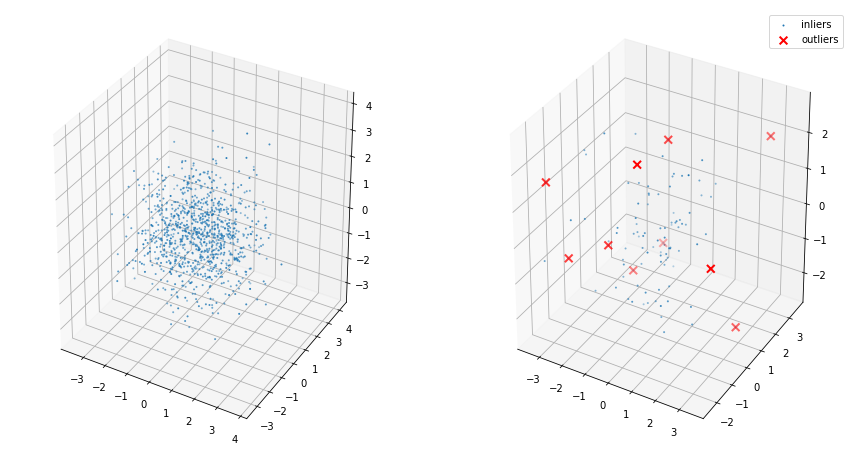

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Start by plotting X
# scale the data 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X2)
# reduce to k=3 dimensions
pca = PCA(n_components=3)  
X_reduce = pca.fit_transform(X_scaled)
# plot the reduced-to-3D data
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = [15, 8])
ax1 = fig.add_subplot(121, projection='3d')
# plot the compressed data points
ax1.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=0)

# Then plot Xval and yval
# scale the data 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xval2)
# reduce to k=3 dimensions
pca = PCA(n_components=3)  
X_reduce = pca.fit_transform(X_scaled)
# plot the reduced-to-3D data
from mpl_toolkits.mplot3d import Axes3D
ax2 = fig.add_subplot(122, projection='3d')
# plot the compressed data points
ax2.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=0, label="inliers")
# Plot x's for the ground truth outliers
ax2.scatter(X_reduce[yval2==1, 0], X_reduce[yval2==1, 1], zs=X_reduce[yval2==1, 2], 
           lw=2, s=60, marker="x", c="red", label="outliers")
ax2.legend()


Now we have an *intuition* of what our data look like, let's:
- estimate the Gaussian parameters ($\mu_i$ and $\sigma_i^2$) for our training data set `X2`;
- calculate the probability density function for our training data `X2` (from which we estimated the Gaussian parameters), and for the the cross-validation set `Xval2` (using the same parameters); and
- use our `selectThreshold()` function to find the best threshold $\varepsilon$.

We should see a value epsilon of about 1.38e-18, and 117 anomalies found (in `X2`)

In [21]:
# Apply the same steps to the larger dataset
mu, sigma_squared = estimateGaussian(X2)

#  Training set 
p = utils.multivariateGaussian(X2, mu, sigma_squared)

#  Cross-validation set
pval2 = utils.multivariateGaussian(Xval2, mu, sigma_squared)

#  Find the best threshold
epsilon, F1 = selectThreshold(yval2, pval2)

print('Best epsilon found using cross-validation: %.2e' % epsilon)
print('Best F1 on Cross Validation Set          : %f\n' % F1)
print('  (you should see a value epsilon of about 1.38e-18)')
print('   (you should see a Best F1 value of      0.615385)')
print('\n# Outliers found: %d' % np.sum(p < epsilon))

Best epsilon found using cross-validation: 1.38e-18
Best F1 on Cross Validation Set          : 0.615385

  (you should see a value epsilon of about 1.38e-18)
   (you should see a Best F1 value of      0.615385)

# Outliers found: 117


### 1.4 Using `scikitlearn`

As usual, I'm keen to explore how to achieve the same outcomes using the `scikitlearn` library - since in most "real" cases I'm going to be using this, or other robust "tried and tested" libraries, rather than spending time coming up with my own functions and classes etc.

`scikitlearn` has a wide range of different modules, classes and methods available for anomaly detection (see 
https://scikit-learn.org/stable/modules/outlier_detection.html for a lengthy discussion). In our case, we are assuming Gaussian distribution, so we can fit an `EllipticEnvelope` object to our data (see https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope)

The `EllipticEnvelope` class takes our unlabelled data and fits a multivariate Guassian probability distribution to it. Let's first apply this to our 2D training data.

In [22]:
from sklearn.covariance import EllipticEnvelope

In [23]:
# fit EllipticEnvelope to training data X
fraction_of_anomalies = 0.02
cov = EllipticEnvelope(contamination = fraction_of_anomalies, random_state = None).fit(X)

Note that the key parameter here is the "contamation" - i.e. the expected proportion of outliers in the dataset. From visualising the data, we know there might be around 7 outliers - which is just over 2%. So we've set contamination to be 0.02. We're going to come back to this in a moment.

The `EllipticEnvelope` class has a `predict()` method which provides us with a prediction for every data point as to whether it is anomalous or not (anomalous points are coded as -1; non-anomalous points are coded as 1). Let's see how many anomalies our model predicts:

In [24]:
# Binary prediction of anomalous vs. non-anomalous
predicted_values = cov.predict(X)
# Anomalous points are predicted as -1
print("The model predicts {} anomalies in our training set".format(sum(predicted_values == -1)))

The model predicts 7 anomalies in our training set


Now let's plot the data. We can use a [`contour plot`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) over a [`meshgrid`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) (which represents our feature plane).

To do this, we're first going to have to access the `decision_function()` method of our model. This returns a continuous value representing the probability density at the input points given. We can then extract the "threshold" value of this decision function, which represents the probability at which the model determines that a value is/isn't anomalous:

In [25]:
# Continuous output of the decision_function
decision = cov.decision_function(X)

# Get the "thresholding" value from the decision function
threshold = stats.scoreatpercentile(decision, 100*fraction_of_anomalies)
threshold

4.8681351652163623e-05

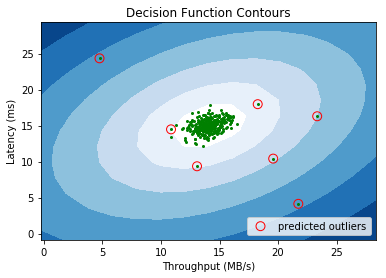

In [26]:
# First make a meshgrid for the (x1, x2) feature space
x1s = np.linspace(np.min(X[:, 0])-5, np.max(X[:, 0])+5, 15)
x2s = np.linspace(np.min(X[:, 1])-5, np.max(X[:, 1])+5, 15)
x1grid, x2grid = np.meshgrid(x1s, x2s) 

# Now make predictions for each point on the grid 
Xgrid = np.column_stack((x1grid.ravel(), x2grid.ravel()))  # Feature matrix containing all grid points
p_density = cov.decision_function(Xgrid)
densiity_grid = p_density.reshape(x1grid.shape)  # Reshape the vector of densities back onto the "grid"


# Use the densites as the "z" values in a contour plot on the grid
fig, ax = plt.subplots()
ax.contourf(x1grid, x2grid, densiity_grid, cmap=plt.cm.Blues_r, levels=np.linspace(p_density.min(), threshold, 7))
ax.scatter(X[:, 0], X[:, 1], s=4, color="g")

# Plot circles around the predicted outliers
ax.scatter(X[predicted_values == -1, 0], X[predicted_values == -1, 1],  
           facecolors="none", edgecolors="red", s=80, label="predicted outliers")

# Add chart title, axes titles, legend
ax.set_title("Decision Function Contours")
ax.set(xlabel = "Throughput (MB/s)")
ax.set(ylabel = "Latency (ms)")
ax.legend(loc="lower right")

Now let's see what this model predicts for our cross-validation data-sets `X_val` and `yval`

In [27]:
predicted_values2 = cov.predict(Xval)
# Remember, anomalous points are predicted as -1
print("The model predicts {} anomalies in our cross-validation set".format(sum(predicted_values2 == -1)))

The model predicts 9 anomalies in our cross-validation set


Let's compare this to the actual values in yval:

In [28]:
np.sum(yval)

9

So, we've predicted the right *number* of outliers - but have we predicted the right ones?

To find out, we're going to want to calculate the F1 score. However, before we do that, we're going to have to transform our `predicted_values2` data. This is because our "ground truth" data in `yval` is encoded as 0 (for non-anomalous) and 1 (for anomalous). Whereas `scikitlearn`'s `EllipticEnvelope()` method encodes non-anomalies as 1, and anomalies as -1. If we try to calculate the F1 score on this raw data, we're going to get a very strange result!

In [29]:
# Replace 1s with 0s
predicted_values2[predicted_values2 == 1] = 0
# Replace -1s with 1s
predicted_values2[predicted_values2 == -1] = 1

In [30]:
np.sum(predicted_values2)

9

That looks right. Now let's calculate the F1 score. Once again, `scikitlearn` has a module for this, which we will use:

In [31]:
from sklearn.metrics import f1_score
f1_score(yval, predicted_values2)

0.77777777777777779

So, an F1-score of ~78% - which, NB, is lower than that we achieved ourselves using our own algorithm, above.

Let's take a closer look at the determinants of our F1-score:

In [32]:
# calculate no. of true positives, false positives...
# ...and false negatives
tp = np.sum(np.logical_and(predicted_values2 == 1, yval == 1)).astype(float)
print("True +ves = {:.3f}".format(tp))
fp = np.sum(np.logical_and(predicted_values2 == 1, yval == 0)).astype(float)
print("False +ves = {:.3f}".format(fp))
fn = np.sum(np.logical_and(predicted_values2 == 0, yval == 1)).astype(float)
print("False -ves = {:.3f}".format(fn))

precision = tp / (tp + fp)
print("Precision is {:.3f}".format(precision))
recall = tp / (tp + fn)
print("Recall is {:.3f}".format(recall))
F1 = (2 * precision * recall) / (precision + recall)

print("Calculated F1 score is {:.3f}".format(F1))

True +ves = 7.000
False +ves = 2.000
False -ves = 2.000
Precision is 0.778
Recall is 0.778
Calculated F1 score is 0.778


So...something *quite surprising* is going on here. Apparently our `scikitlearn` model fits the data ***quite a lot worse*** than our own function (our `scikitlearn` imlementation achieves an F1-score of ~78%, compared with ~88% from our own function). What's going on?

Well, let's come back to that all-important `contamination` parameter.

My response on reading about this parameter was:

<span style="color: blue; font-size: 100%; font-weight: bold">***Wait, what?!***</span>

<span style="color: blue; font-size: 100%">*We have to <u>guess</u> how many outliers there are in the data, and set this as a parameter to the model?!*</span>

<span style="color: blue; font-size: 100%">*But, this is supposed to be <u>unsupervised learning</u>. So how do we come up with a sensible guess for the proportion of outliers? Especially when we move up to 11D data, and we can't even look at it?*</span>

Having to guess how many outliers are in the data *before* we run a model for which the objective is *to work out which data points are outliers* seems...er...unsatisfactory!

And it seems that our guess may not have been that good even in this simple 2D case, where we could visualize the data and manually choose what we thought was an appropriate value for the parameter.

So, what can we do?

Well, for our own function, recall that we iterated through a large number of potential values of our threshold value, $\varepsilon$, in order to find the value that gave us the best F1-score (see section 1.2 above). We can apply a similar approach to finding the best value for the `contamination` parameter for `EllipticEnvelope`. First we're going to to code this ourselves, training different values of the `contamination` parameter on our training data `X`, and then testing performance on `Xval` and `yval`:

In [33]:
# create a dict to hold the results
results = {}

# set a range of different values for contaminations from 0.5% to 5%
contaminations = np.linspace(0.005, 0.05)
bestF1 = 0
for contamination in contaminations:
    # train the model
    cov = EllipticEnvelope(contamination = contamination, random_state = None).fit(X)
    # predict anomalies on Xval
    preds = cov.predict(Xval)
    # Replace 1s with 0s
    preds[preds == 1] = 0
    # Replace -1s with 1s
    preds[preds == -1] = 1
    # calculate F1 score of predictions vs. yval
    F1 = f1_score(yval, preds)
    # add the outcome to a dict of all the results
    results[contamination] = F1
    if F1 > bestF1:
        bestF1 = F1
        bestContamination = contamination
    
print("Optimum value found for contamination is {}, with an F1-score of {}".format(bestContamination, bestF1))

Optimum value found for contamination is 0.013265306122448979, with an F1-score of 0.8750000000000001


If we're going to use our unlabelled data to train the model, I think this is probably the best approach we can take. We might take a couple of passes at the training, first using a broad selection of values for the `contamination` parameter, to identify the right *range* of values for good performance; and then running our loop in a more fine-grained way to optimize better (e.g. in our case, looking at values between say 0.01 and 0.03) - though this *might* result in over-fitting.

However, there is an alternative, which is to use our *labelled* data for both *training* and *validation* - using a technique called "K-fold cross-validation". The main idea here is that we take our labelled data set and randomly split it (or "fold" it) into *k* sets. We then train our algorithm on a sub-set made up of *k-1* sets; and then train on the last set (or "fold"). We repeat this process multiple times - as many times as there are different values of the parameters we want to look at. By doing this, we effectively create multiple different training and test sets from our original data set. Note that this is an example of "supervised" learning. For a lengthier discussion of K-fold validation, you could start [here](https://en.wikipedia.org/wiki/Cross-validation_(statistics) and [here](https://scikit-learn.org/stable/modules/cross_validation.html).

In our case, because we have highly skewed classes (because we only have a few outliers), we need to use a modification of k-fold cross-validation called "Stratified K-fold cross-validation", in which we ensure that when we divide up our data into different sets, we nonetheless a representative balance of examples in each set (or "fold"). We can do this in `scikitlearn` using the `StratifiedKFold` class [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html).

We can also improve on our use of the for-loop above by using `scikitlearn`'s `GridSearch()` module. Briefly, [`GridSearch()`](https://scikit-learn.org/stable/modules/grid_search.html) allows us to set out a range of parameters (technically, "hyperparameters") for our model, and then systematically and exhaustively "fit" our model to the dataset using all the possible combinations of parameter values, which are then evaluated and the best combination retained.

One annoying wrinkle is that the default scoring metric used by the `EllipticEnvelope` class is mean scoring accuracy - which is *really bad* way to score when we have skewed classes (basically we can get a really high score just by predicting *no* data points are in the low-representation class...for more on this Professor Ng explains this clearly in the previous week's lectures). We can resolve this, however, by setting the metric we use to be the F1 score, using `scikitlearn`'s `make_scorer()` method.

OK, let's do this:

In [34]:
# this time, we'll convert yval into -1 / 1 encoding
# we'll do this on a copy of yval so that we can
# go back and re-run our previous code on the original yval
yval_converted = np.copy(yval)
yval_converted = yval_converted.astype(np.int8)
yval_converted[yval_converted == 1] = -1
yval_converted[yval_converted == 0] = 1

# import and instantiate a stratified k-fold object
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3)
folds = list(skf.split(Xval, yval_converted))

# define our scoring metric to be the F1 score
from sklearn.metrics import f1_score, make_scorer
f1sc = make_scorer(f1_score)

# instantiate our EllipticEnvelope object and train it on Xval
cov = EllipticEnvelope()
cov.fit(Xval)

# import and instantiate a GridSearchCV object
from sklearn.model_selection import GridSearchCV
parameters_to_test = {"contamination": np.linspace(0.0, 0.05, 15)}
search = GridSearchCV(estimator=cov, param_grid=parameters_to_test, scoring=f1sc, cv=folds)
search.fit(Xval, yval_converted)

GridSearchCV(cv=[(array([102, 103, ..., 305, 306]), array([  0,   1, ..., 101, 300])), (array([  0,   1, ..., 305, 306]), array([102, 103, ..., 302, 303])), (array([  0,   1, ..., 302, 303]), array([201, 202, ..., 305, 306]))],
       error_score='raise',
       estimator=EllipticEnvelope(assume_centered=False, contamination=0.1, random_state=None,
         store_precision=True, support_fraction=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'contamination': array([ 0.     ,  0.00357,  0.00714,  0.01071,  0.01429,  0.01786,
        0.02143,  0.025  ,  0.02857,  0.03214,  0.03571,  0.03929,
        0.04286,  0.04643,  0.05   ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score), verbose=0)

Let's put the results into a data-frame and have a look at the scores:

In [35]:
df = pd.DataFrame(search.cv_results_)
df[["mean_test_score", "std_test_score", "params"]].sort_values(by=["mean_test_score"], ascending=False)

,mean_test_score,std_test_score,params
5,0.996678,0.004675,{'contamination': 0.0178571428571}
4,0.995009,0.004045,{'contamination': 0.0142857142857}
6,0.993288,0.004736,{'contamination': 0.0214285714286}
3,0.990050,0.003985,{'contamination': 0.0107142857143}
7,0.989880,0.004204,{'contamination': 0.025}
0,0.988413,0.004629,{'contamination': 0.0}
1,0.988413,0.004629,{'contamination': 0.00357142857143}
2,0.988413,0.004629,{'contamination': 0.00714285714286}
8,0.988141,0.006486,{'contamination': 0.0285714285714}
9,0.984716,0.004380,{'contamination': 0.0321428571429}


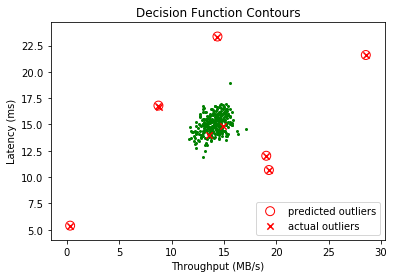

In [36]:
# Make predictions with our optimized envelope fit
optimal_cov = search.best_estimator_
predictions = optimal_cov.predict(Xval)

# Use the densites as the "z" values in a contour plot on the grid
fig, ax = plt.subplots()
ax.scatter(Xval[:, 0], Xval[:, 1], s=4, color="g")

# Plot circles around the predicted outliers
ax.scatter(Xval[predictions == -1, 0], Xval[predictions == -1, 1],  
           facecolors="none", edgecolors="red", s=80, label="predicted outliers")

# Plot x's for the actual truth outliers
ax.scatter(Xval[yval_converted == -1, 0], Xval[yval_converted == -1, 1], marker="x", 
           color="r", s=40, label="actual outliers")

# Add chart title, axes titles, legend
ax.set(title = "Decision Function Contours", xlabel = "Throughput (MB/s)", ylabel = "Latency (ms)")
ax.legend(loc="lower right")

Our *supervised* learning algorithm seems to have done pretty well!

For the sake of completeness, let's apply the same technique to our higher-dimensional data, too.

First of all, we'll convert our y data into "1, -1" encoding:

In [37]:
yval2_converted = np.copy(yval2)
yval2_converted = yval2_converted.astype(np.int8)
yval2_converted[yval2_converted ==1] = -1
yval2_converted[yval2_converted ==0] = 1

In [38]:
# Grid Search over contamination fraction
skf = StratifiedKFold(n_splits=3)
folds = list(skf.split(Xval2, yval2_converted))
ell = EllipticEnvelope()
f1sc = make_scorer(f1_score)
ps = {"contamination": np.linspace(0.0, 0.05, 15)}
search = GridSearchCV(estimator=ell, param_grid=ps, scoring=f1sc, cv=folds)
search.fit(Xval2, yval2_converted)

GridSearchCV(cv=[(array([34, 35, ..., 98, 99]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])), (array([ 0,  1, ..., 98, 99]), array([34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
      ...7, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]))],
       error_score='raise',
       estimator=EllipticEnvelope(assume_centered=False, contamination=0.1, random_state=None,
         store_precision=True, support_fraction=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'contamination': array([ 0.     ,  0.00357,  0.00714,  0.01071,  0.01429,  0.01786,
        0.02143,  0.025  ,  0.02857,  0.03214,  0.03571,  0.03929,
        0.04286,  0.04643,  0.05   ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score), verbose=0)

Now we can use our optimal elliptic envelope to make predictions on the true values of Xval2:

In [39]:
# Make predictions with our optimized envelope fit
optimal_cov = search.best_estimator_
predictions = optimal_cov.predict(Xval2)

Let's take a look at the results:

In [40]:
df = pd.DataFrame(search.cv_results_)
df[["mean_test_score", "std_test_score", "params"]].sort_values(by=["mean_test_score"], ascending=False)

,mean_test_score,std_test_score,params
6,0.973136,0.007515,{'contamination': 0.0214285714286}
7,0.973136,0.007515,{'contamination': 0.025}
8,0.973136,0.007515,{'contamination': 0.0285714285714}
9,0.973136,0.007515,{'contamination': 0.0321428571429}
10,0.973136,0.007515,{'contamination': 0.0357142857143}
11,0.973136,0.007515,{'contamination': 0.0392857142857}
12,0.973136,0.007515,{'contamination': 0.0428571428571}
13,0.973136,0.007515,{'contamination': 0.0464285714286}
14,0.973136,0.007515,{'contamination': 0.05}
5,0.968067,0.012780,{'contamination': 0.0178571428571}


We seem to be getting pretty good F1-scores - over 97% for our optimal value of `contamination`.

Now let's visualise the predictions. Remember, the data we have been operating on is 11-dimensional, so in order to visualise them, we're going to need to project from 11D to 3D using our PCA algorithm:

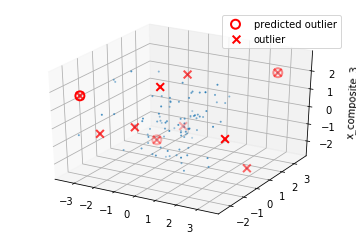

In [41]:
# Plot all the reduced-dimensionality ground truth points together with the predictions
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")

# Plot the reduced dimensionality data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=0)

# Plot circles around the predicted outliers
ax.scatter(X_reduce[predictions == -1, 0], X_reduce[predictions == -1, 1], zs=X_reduce[predictions == -1, 2], 
           lw=2, facecolors="none", edgecolors="r", s=80, label="predicted outlier")

# Plot x's for the ground truth outliers
ax.scatter(X_reduce[yval2_converted == -1, 0], X_reduce[yval2_converted == -1, 1], zs=X_reduce[yval2_converted == -1, 2], 
           lw=2, s=60, marker="x", c="red", label="outlier")
ax.legend()

Hmm. It looks like we've missed quite a few outliers. This is despite the fact that we have achieved pretty good F1 scores. The reason for this is not totally clear to me, but I think it may be because we trying to fit the multivariate Gaussian to a data set where m is not >> than n (i.e. we don't have vastly more data points than features).

**That wraps up the first part of the programming exercise.**

In terms of next steps that might be interesting to explore:

1) One thing that would be interesting to explore with more time, would be to look at the difference in outputs of the "multivariate" approach vs. the "product of feature probabilities" approach; and to see how computational performance for the "multivariate" approach changes with large values of *n*, and where *m* is not much larger than *n*. (Hint: for large *n*, the multivariate approach will be computationally very expensive; and as *m* approaches *n*, we may find cases where the inversion of the co-variance matrix will be non-invertible - and therefore the multivariate approach cannot be calculated).

2) It would be good to understand better the limits of when the multivariate approach breaks down. In our *supervised* fitting of the multivariate Gaussian to high-dimensional data set above, we have of the order of $n^2$ data points (where *n* is the number of features) - which ought to be sufficient for good performance.

If you're interested in the second part of this week's exercises - on recommender systems - you may wish to take a look at my second notebook.